In [65]:
import random
import networkx as nx
import math
import osmnx as ox
import pandas as pd
import ast

### Trip Class

In [51]:
class Trip(object):
    
    # Defining class variable
    def __init__(self, Trip):
        self.Trip = Trip
        self.origin = Trip[0]
        self.dest = Trip[1]
    
    # Determines the shortest trip between the origin and destination without considering range of vehicle
    def shortest_theoretical_trip(self, G):
        unserviced_trip = {}

        unserviced_trip['Distance'] = nx.shortest_path_length(G, self.origin, self.dest, weight = 'distance')
        unserviced_trip['Path'] = nx.shortest_path(G, self.origin, self.dest, weight = 'distance')

        return unserviced_trip
    
    # Determines the shortest trip between the origin and destination considering range of vehicle & ev charger locations
    def shortest_serviced_trip(self, G, ev_chargers, veh_range):
        
        # Finds the shortest theoretical trip
        shortest_trip = self.shortest_theoretical_trip(G)
        uncharged_dist = list(shortest_trip.values())[0]

        # Creating dictionary for the trip information
        serviced_trip = {}
        
        # If trip distance is less than the range of the vehicle
        if uncharged_dist <= veh_range:
            serviced_trip = shortest_trip

        # If the trip distance is greater than the range of the vehicle
        else:
            serviced_routes = []

            # Creates a sorted list of the graph's nodes
            nodes = sorted(G.nodes())
            
            # Goes through ev charger locations
            for i in range(len(ev_chargers)):

                # If the node has a charger
                if ev_chargers[i] == 1:

                    # Finds shortest distance from origin to EV charger and from EV charger to destination
                    len_to = nx.shortest_path_length(G, self.origin, nodes[i], weight = 'distance')
                    len_from = nx.shortest_path_length(G, nodes[i], self.dest, weight = 'distance')

                    # Finds shortest path from origin to EV charger and from EV charger to destination
                    #path_to = nx.shortest_path(G, self.origin, nodes[i], weight = 'distance')
                    #path_from = nx.shortest_path(G, nodes[i], self.dest, weight = 'distance')

                    # If vehicle can't reach an EV charger or EV charger is too close to origin or EV charger is too far from destination, 
                    # apply unserviced number (a massive number)
                    if len_to > veh_range or len_to < (uncharged_dist - veh_range) or len_from > veh_range:
                        len_tot = unserviced_num

                    else:
                        len_tot = len_to + len_from

                    serviced_routes.append(len_tot)

            # Use the lowest trip distance that accounts for a potential stop at a EV charger
            serviced_trip['Distance'] = min(serviced_routes)
            #serviced_trip['Path'] = path_to + path_from[1:]              

        return serviced_trip

### Chromosome Class

In [52]:
class Chromosome(object):

    # Defining class variable
    def __init__(self, chromosome, num_node, num_charger):
        self.chromosome = chromosome
        self.nodes = num_node
        self.chargers = num_charger

    # Generates a new chromosome
    @classmethod
    def create_new(self, num_node, num_charger):

        new_chromosome = [1] * num_charger + [0] * (num_node-num_charger)

        random.shuffle(new_chromosome)

        return self(new_chromosome, num_node, num_charger)
    
    def create_mutant(self, charger_loc):

        new_chromosome = [0] * self.nodes
        for i in charger_loc:
            new_chromosome[i] = 1

        return Chromosome(new_chromosome, self.nodes, self.chargers)
    
    # Replaces duplicate EV charger locations
    def replace_duplicates(self, lst):

        seen = set()

        for i in range(len(lst)):

            while lst[i] in seen:
                lst[i] = random.randint(0, self.nodes - 1)
            
            seen.add(lst[i])

        return lst

    # Crossover Function
    def crossover(self, second_parent):

        # creating chromosome for a child
        child_chromosome_locs = []

        # Creating lists containing EV Charger locations
        first_parent_locs = self.locate_chargers()
        second_parent_locs = second_parent.locate_chargers()

        # Option #2 - One-Point Crossover
        child_chromosome_locs = first_parent_locs[:math.ceil(len(first_parent_locs)/2)] + second_parent_locs[math.ceil(len(second_parent_locs)/2):]

        # Removes and replaces duplicates before creating a new chromosome
        child_chromosome_locs = self.replace_duplicates(child_chromosome_locs)

        # Creates a new chromosome with the new charging locations
        child_chromosome = self.create_mutant(child_chromosome_locs)
        
        # Generating the child
        return child_chromosome
    
    # Returns list of nodes where chargers are located
    def locate_chargers(self):
        return [index for index, value in enumerate(self.chromosome) if value == 1]
    
    def mutate(self):

        charger_loc = self.locate_chargers()

        prob = random.random()

        # If prob is less than 0.5, less than or equal to a third of charger locations is changed
        if prob < 0.7:
            n = math.ceil(len(charger_loc)/3)

            if n == 0:
                n = 1

        # If prob is less than 0.7, less than or equal to half of charger locations are changed
        elif prob < 0.9:
            n = math.ceil(len(charger_loc)/2)
        
        else:
            n = 0

        for i in range(n):

            # A random charger in the charger_loc list is selected
            rand_charger = random.randint(0, len(charger_loc) - 1)

            seen = set(charger_loc)

            # Find a unique new location for the charger
            while charger_loc[rand_charger] in seen:
                charger_loc[rand_charger] = random.randint(0, self.nodes - 1)

        # Creates a new chromosome with the new charging locations
        mutated_chromosome = self.create_mutant(charger_loc)

        return mutated_chromosome

    def fitness(self, G, trip_nodes, veh_range):

        # Add list of length of trip_nodes with 1 if trip is serviced and 0 if trip is not serviced so we know which trips are serviced and which aren't

        tot_distance = 0

        for i in trip_nodes:
            serviced_trip = i.shortest_serviced_trip(G, self.chromosome, veh_range)
            tot_distance += serviced_trip['Distance']

        return tot_distance

## Helper Functions

In [54]:
def print_graph(G, ev_locs):

    node_colors = []
    node_sizes = []
    ev_nodes = []

    # Finding the graph nodes where EV chargers are located
    for i in ev_locs:
        ev_nodes.append(sorted(G.nodes())[i])

    # Setting the color and size of graph nodes
    for id in G.nodes():

        if id in ev_nodes:
            node_colors.append("#00FF00")
            node_sizes.append(30)
            
        else:
            node_colors.append("#FFFFFF")
            node_sizes.append(.1)

    # Ploting graph using OSMnx
    ox.plot_graph(G, node_color = node_colors, node_size = node_sizes, edge_color='#000000', bgcolor = '#F8F8FF', edge_linewidth=0.5)


## Genetic Algorithm

### Graph Creation

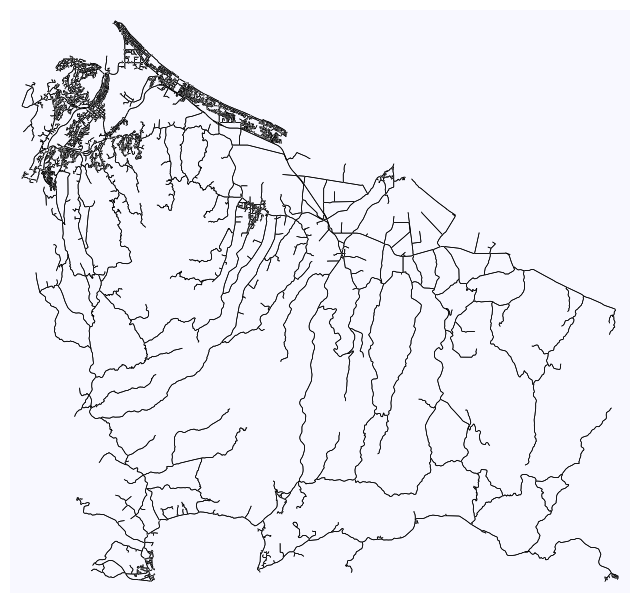

In [79]:
# Creates/Imports Graph
bbox = -37.6, -38.09, 176.7, 176.08
G_org = ox.graph_from_bbox(bbox = bbox, network_type='drive')
ox.plot_graph(G_org, node_size = .1, node_color = '#FFFFFF', edge_color='#000000', bgcolor = '#F8F8FF', edge_linewidth=0.5);

Create a strongly connected subgraph

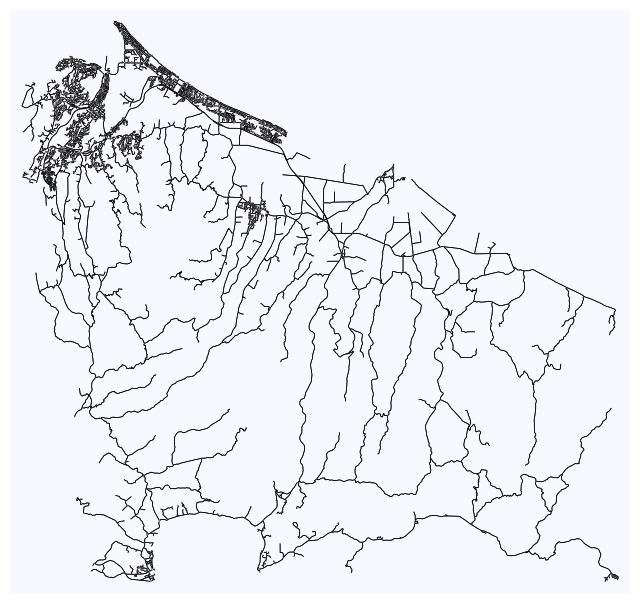

In [80]:
# Creates a strongly connected subgraph using NetworkX
component = max(nx.strongly_connected_components(G_org), key=len)
G = G_org.subgraph(component).copy()

ox.plot_graph(G, node_size = .1, node_color = '#FFFFFF', edge_color='#000000', bgcolor = '#F8F8FF', edge_linewidth=0.5);

### Trip Data

Import Census Trip Data

In [101]:
# Initialises Global Trip DataFrame (COPY YOUR OWN FILE PATH)
df_trips_coor = pd.read_csv(r"C:\Users\samga\Documents\UAuck\Y4S1\CIVIL705\Project Files\Code\Census Trip Data\Rural Trip Data\Pongakawa_Census_Trip_Data_2024-08-19_10.36.csv", dtype = 'a')

Convert Coordinates into Node Data

In [102]:
# Initialising key lists
nodes_lat = []
nodes_lon = []

col_count = df_trips_coor.count()

# Collating all latitude and longitude numbers into two lists for the nearest_nodes function from OSMnx
for col in range(0, df_trips_coor.shape[1]):

    for row in range(0, col_count[col]):
        
        pts_lat = [pair[0] for pair in ast.literal_eval(df_trips_coor.iloc[row, col])]
        pts_lon = [pair[1] for pair in ast.literal_eval(df_trips_coor.iloc[row, col])]
        nodes_lat.extend(pts_lat)
        nodes_lon.extend(pts_lon)

# Converting latitude and longitude coordinates to node IDs within graph G
nodes_id = ox.distance.nearest_nodes(G, nodes_lon, nodes_lat, return_dist=False)

# Collating all node IDs into a DataFrame with Origin and Destination nodes in two separate columns
list_origin = []
list_dest = []

for i in range(0, len(nodes_id)):
    index = int(i/2)
    if i%2 == 0:
        list_origin.append(nodes_id[i])
    elif i%2 == 1:
        list_dest.append(nodes_id[i])

df_trips = pd.DataFrame({'Origins': list_origin, 'Destinations': list_dest})

C:\Users\samga\AppData\Local\Temp\ipykernel_8220\3976153972.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for row in range(0, col_count[col]):


Create Trip Objects using Trip Data

In [107]:
# Creating a list with all the O-D pairs stored as Trip objects
T = []

for row in range(0, df_trips.shape[0]):

    node_origin = df_trips.iloc[row, 0]
    node_dest = df_trips.iloc[row, 1]

    T.append(Trip([node_origin, node_dest]))

1440186250

### Key Variables

In [108]:
# Sets key variables
num_nodes = G.number_of_nodes()
no = sorted(G.nodes())
num_chargers = 2
veh_range = 80
num_trips = len(T)
max_trip_length = 100

# Maximum acceptable percentage of trips not serviced
max_unserved = 0.01

# Fitness value if trip is not serviced
unserviced_num = num_trips*max_trip_length

# Number of generation iterations with same top chromosome
max_itr = 10

### GA Analysis

In [11]:
# Sets number of chromosomes in population
pop_size = 10

# Creates first generation
generation = 1

# Initialises population
population = []

# Initialising while loop condition
solution_found = False

# Creates initial population
for i in range(pop_size):
    population.append(Chromosome.create_new(num_nodes, num_chargers))

# Keeps record of fittest chromosomes
fittest = []

# Continues until the final generation is met
while not solution_found:

    # Sorts chromosome by fitness score
    population = sorted(population, key = lambda x:x.fitness(G, T, veh_range))

    # Checks if fittest chromosome fulfills requirement
    if population[0].fitness(G, T, veh_range) <= int(max_unserved*num_trips+1)*unserviced_num:
        solution_found = True
        print(f"A total of {round(((population[0].fitness(G, T, veh_range))//unserviced_num)/num_trips*100, 2)}% of trips are not possible which is below the requirement of {max_unserved*num_trips}% of trips.""")
        break
    
    new_generation = []

    # SELECTION: Top 15% fittest population is kept through elitism selection
    x = int((15*pop_size)/100)
    new_generation.extend(population[:x])

    # CROSSOVER & MUTATION: Top 50% undergoes crossover and mutation
    x = int((85*pop_size)/100)
    for _ in range(x):
        first_parent = random.choice(population[:50])
        second_parent = random.choice(population[:50])
        child = first_parent.crossover(second_parent)
        child = child.mutate()
        new_generation.append(child)

    # Creates new generation
    population = new_generation

    # Displays the fittest chromosome in the population in that generation
    print("Generation Number: {}\tSolution: {}\tFitness Score: {}".format(generation,population[0].locate_chargers(),population[0].fitness(G, T, veh_range)))

    # Adds fittest chromosome to the list
    fittest.append(population[0].locate_chargers())

    # If fittest chromosome has appeared more than 3 times, end algorithm
    if fittest.count(population[0].locate_chargers()) > max_itr:
        solution_found = True
        print(f"""The best solution was found given the max iteration limit of {max_itr}. A total of {round(((population[0].fitness(G, T, veh_range))//unserviced_num)/num_trips*100, 2)}"""
              """% of trips are not possible.""")
        break

    # Next generation
    generation += 1

# printing the fittest chromosome in last generation along with the fittness score
print("Final Generation Number: {}\tSolution: {}\tFitness Score: {}".format(generation,population[0].locate_chargers(),population[0].fitness(G, T, veh_range)))
print_graph(G, population[0].locate_chargers())


Generation Number: 1	Solution: [6772, 10453]	Fitness Score: 106518
Generation Number: 2	Solution: [6772, 10453]	Fitness Score: 106518
Generation Number: 3	Solution: [6772, 10453]	Fitness Score: 106518
Generation Number: 4	Solution: [6759, 10453]	Fitness Score: 96797
Generation Number: 5	Solution: [6759, 10453]	Fitness Score: 96797
Generation Number: 6	Solution: [6759, 10453]	Fitness Score: 96797
Generation Number: 7	Solution: [6759, 10453]	Fitness Score: 96797
Generation Number: 8	Solution: [5724, 7744]	Fitness Score: 57162
Generation Number: 9	Solution: [5724, 7744]	Fitness Score: 57162
Generation Number: 10	Solution: [5724, 7744]	Fitness Score: 57162
Generation Number: 11	Solution: [5724, 7744]	Fitness Score: 57162
Generation Number: 12	Solution: [5724, 7744]	Fitness Score: 57162
Generation Number: 13	Solution: [5724, 7744]	Fitness Score: 57162
Generation Number: 14	Solution: [5724, 7744]	Fitness Score: 57162


### Graph Printing

Final Generation Number: 17	Solution: [5617, 7611]	Fitness Score: 126238


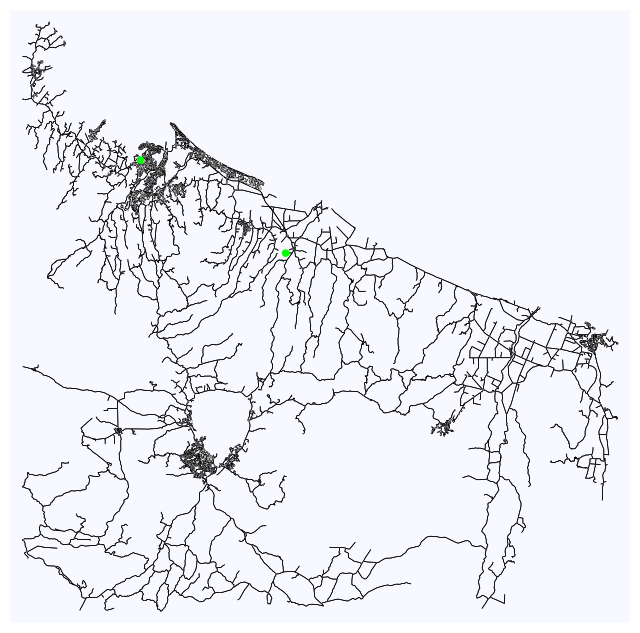

In [43]:
print("Final Generation Number: {}\tSolution: {}\tFitness Score: {}".format(generation,population[0].locate_chargers(),population[0].fitness(G, T, veh_range)))
print_graph(G, population[0].locate_chargers())